This notebook generates cumulative precipitation plots, precipitation duration curves, and dry-length period statistics. These diagnostics are useful for comparing precipitation characteristics between the CARAVAN and CAMELS datasets. It also creates hydrographs with precipitation barplots on top, which are useful for visually assessing the influence of precipitation on streamflow.

In [1]:
from pathlib import Path
import sys
import pandas as pd
import torch
import matplotlib.pyplot as plt
import xarray as xr
import yaml
import geopandas as gpd
import contextily as cx
from adjustText import adjust_text
import numpy as np
import pickle

In [2]:
# ------- Paths -------
data_caravan=Path("../preparing_data/filtered_data/time_series")
data_uy_gauge=Path("../preparing_data/filtered_data_gauge_precip/time_series")
# data_uy_new_precip=Path("../data_uy_new_precip/time_series")


In [3]:
caravan = xr.open_dataset(data_caravan / "CAMELS_UY_3.nc")
uy_gauge = xr.open_dataset(data_uy_gauge / "CAMELS_UY_3.nc")

In [4]:
caravan

<xarray.Dataset> Size: 362kB
Dimensions:      (date: 11322)
Coordinates:
  * date         (date) datetime64[ns] 91kB 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    tmin_C       (date) float32 45kB ...
    tmax_C       (date) float32 45kB ...
    srad_W_m2    (date) float32 45kB ...
    prcp_mm_day  (date) float32 45kB ...
    QObs_mm_d    (date) float64 91kB ...

In [5]:
uy_gauge

<xarray.Dataset> Size: 362kB
Dimensions:      (date: 11322)
Coordinates:
  * date         (date) datetime64[ns] 91kB 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    tmin_C       (date) float32 45kB ...
    tmax_C       (date) float32 45kB ...
    srad_W_m2    (date) float32 45kB ...
    prcp_mm_day  (date) float32 45kB ...
    QObs_mm_d    (date) float64 91kB ...
Attributes:
    precip_update:  Gauge data used where available

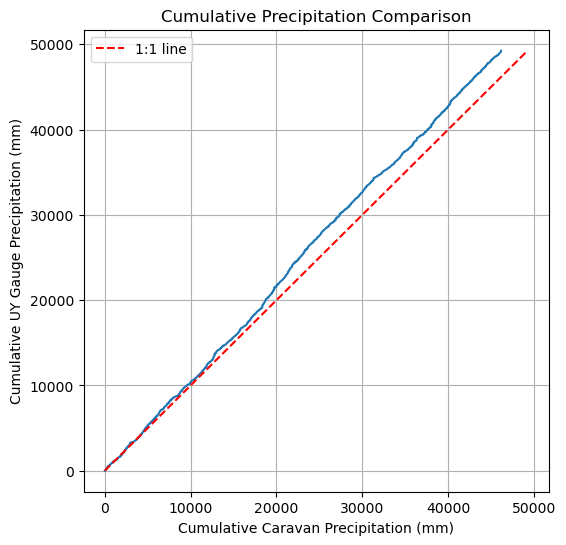

In [6]:
import matplotlib.pyplot as plt
import xarray as xr

# Align by date first (so we sum over the same days)
precip_caravan = caravan['prcp_mm_day']
precip_uy = uy_gauge['prcp_mm_day']
precip_caravan_aligned, precip_uy_aligned = xr.align(precip_caravan, precip_uy, join='inner')

# Compute cumulative precipitation for both series
cum_caravan = precip_caravan_aligned.cumsum(dim='date').values.flatten()
cum_uy = precip_uy_aligned.cumsum(dim='date').values.flatten()

# Scatter plot: x = Caravan, y = UY gauge
plt.figure(figsize=(6,6))
plt.plot(cum_caravan, cum_uy)
plt.xlabel('Cumulative Caravan Precipitation (mm)')
plt.ylabel('Cumulative UY Gauge Precipitation (mm)')
plt.title('Cumulative Precipitation Comparison')
plt.grid(True)

# Optional: 1:1 line to see perfect agreement
max_val = max(cum_caravan.max(), cum_uy.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 line')
plt.legend()
plt.show()

Skipping basin 12, file missing.


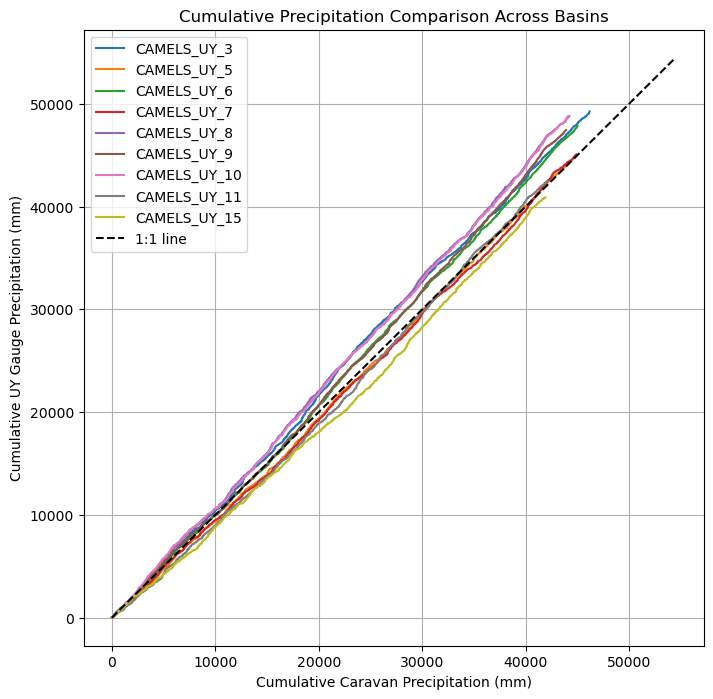

In [7]:
# List of basins
basins = [3,5,6,7,8,9,10,11,12,15]

plt.figure(figsize=(8,8))

for b in basins:
    # Construct file paths
    caravan_file = data_caravan / f"CAMELS_UY_{b}.nc"
    uy_file = data_uy_gauge / f"CAMELS_UY_{b}.nc"
    
    # Skip if either file is missing
    if not caravan_file.exists() or not uy_file.exists():
        print(f"Skipping basin {b}, file missing.")
        continue
    
    # Open datasets
    caravan_ds = xr.open_dataset(caravan_file)
    uy_ds = xr.open_dataset(uy_file)
    
    # Extract precipitation variable (replace with correct variable names)
    # Here I assume Caravan = 'total_precipitation_sum', UY gauge = 'prcp_mm_day'
    caravan_precip = caravan_ds['prcp_mm_day']
    uy_precip = uy_ds['prcp_mm_day']
    
    # Align by date
    caravan_aligned, uy_aligned = xr.align(caravan_precip, uy_precip, join='inner')
    
    # Cumulative sum
    cum_caravan = caravan_aligned.cumsum(dim='date').values.flatten()
    cum_uy = uy_aligned.cumsum(dim='date').values.flatten()
    
    # Scatter plot
    plt.plot(cum_caravan, cum_uy, label=f'CAMELS_UY_{b}')

# Add 1:1 line
all_max = max([cum_caravan.max(), cum_uy.max()])
plt.plot([0, all_max*1.3], [0, all_max*1.3], 'k--', label='1:1 line')

plt.xlabel('Cumulative Caravan Precipitation (mm)')
plt.ylabel('Cumulative UY Gauge Precipitation (mm)')
plt.title('Cumulative Precipitation Comparison Across Basins')
plt.legend()
plt.grid(True)
plt.show()


# CAMELS_UY_6

In [8]:
caravan_6 = xr.open_dataset(data_caravan / "CAMELS_UY_6.nc")
uy_gauge_6 = xr.open_dataset(data_uy_gauge / "CAMELS_UY_6.nc")
# new_precip_6 = xr.open_dataset(data_uy_new_precip / "CAMELS_UY_6.nc")


In [9]:
start_date = pd.to_datetime("1989-10-01")
end_date   = pd.to_datetime("2008-09-30")

In [10]:
caravan_6 = caravan_6.sel(date=slice(start_date, end_date))
uy_gauge_6 = uy_gauge_6.sel(date=slice(start_date, end_date))

In [11]:
print(caravan_6.date.min().values, caravan_6.date.max().values)
print(uy_gauge_6.date.min().values, uy_gauge_6.date.max().values)
# print(new_precip_6.date.min().values, new_precip_6.date.max().values)

1989-10-01T00:00:00.000000000 2008-09-30T00:00:00.000000000
1989-10-01T00:00:00.000000000 2008-09-30T00:00:00.000000000


In [12]:
uy_gauge_6

<xarray.Dataset> Size: 222kB
Dimensions:      (date: 6940)
Coordinates:
  * date         (date) datetime64[ns] 56kB 1989-10-01 1989-10-02 ... 2008-09-30
Data variables:
    tmin_C       (date) float32 28kB ...
    tmax_C       (date) float32 28kB ...
    srad_W_m2    (date) float32 28kB ...
    prcp_mm_day  (date) float32 28kB ...
    QObs_mm_d    (date) float64 56kB ...
Attributes:
    precip_update:  Gauge data used where available

In [13]:
caravan_6

<xarray.Dataset> Size: 222kB
Dimensions:      (date: 6940)
Coordinates:
  * date         (date) datetime64[ns] 56kB 1989-10-01 1989-10-02 ... 2008-09-30
Data variables:
    tmin_C       (date) float32 28kB ...
    tmax_C       (date) float32 28kB ...
    srad_W_m2    (date) float32 28kB ...
    prcp_mm_day  (date) float32 28kB ...
    QObs_mm_d    (date) float64 56kB ...

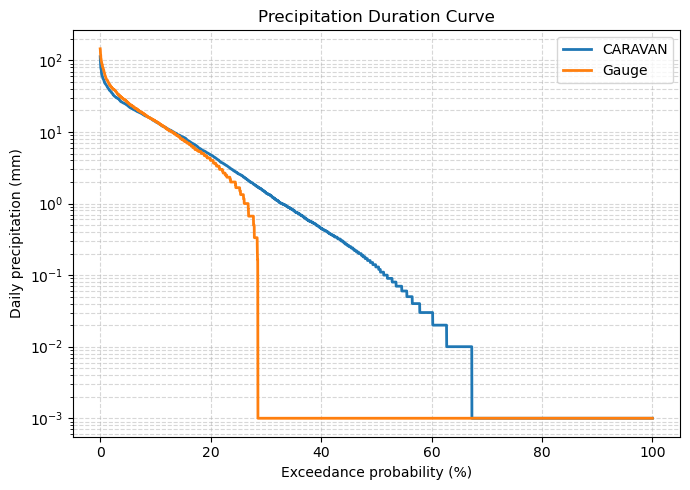

In [14]:
# --- Extract precipitation ---
pr_caravan = caravan_6["prcp_mm_day"].values
pr_gauge = uy_gauge_6["prcp_mm_day"].values
# pr_new = new_precip_6["prcp_mm_day"].values


# --- Flatten & remove NaNs ---
pr_caravan = pr_caravan[~np.isnan(pr_caravan)]
pr_gauge = pr_gauge[~np.isnan(pr_gauge)]
# pr_new = pr_new[~np.isnan(pr_new)]

# # --- Remove zero-precipitation days ---
# pr_caravan = pr_caravan[pr_caravan > 0]
# pr_gauge = pr_gauge[pr_gauge > 0]

# --- Sort descending ---
pr_caravan_sorted = np.sort(pr_caravan)[::-1]
pr_gauge_sorted = np.sort(pr_gauge)[::-1]
# pr_new_sorted = np.sort(pr_new)[::-1]

# --- Exceedance probabilities ---
n_caravan = len(pr_caravan_sorted)
n_gauge = len(pr_gauge_sorted)
# n_new = len(pr_new_sorted)

ep_caravan = np.arange(1, n_caravan + 1) / (n_caravan + 1) * 100
ep_gauge = np.arange(1, n_gauge + 1) / (n_gauge + 1) * 100
# ep_new = np.arange(1, n_new + 1) / (n_new + 1) * 100

# --- Plot ---
pr_caravan_plot = np.where(pr_caravan_sorted==0, 1e-3, pr_caravan_sorted)
pr_gauge_plot   = np.where(pr_gauge_sorted==0, 1e-3, pr_gauge_sorted)
# pr_new_plot   = np.where(pr_new_sorted==0, 1e-3, pr_new_sorted)

plt.figure(figsize=(7, 5))

plt.plot(ep_caravan, pr_caravan_plot, label="CARAVAN", lw=2)
plt.plot(ep_gauge, pr_gauge_plot, label="Gauge", lw=2)
# plt.plot(ep_new, pr_new_plot, label="MSWEP_V280", lw=2)

plt.xlabel("Exceedance probability (%)")
plt.ylabel("Daily precipitation (mm)")
plt.yscale("log")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.title("Precipitation Duration Curve")

plt.tight_layout()
plt.show()

## Statistics for uy_gauge_6 and caravan_6_trimmed:

### Number of rainy days

In [15]:
caravan_zero_count = np.sum(pr_caravan == 0.0)
print("Number of exact zeros (CARAVAN):", caravan_zero_count)

Number of exact zeros (CARAVAN): 2270


In [16]:
gauge_zero_count = np.sum(pr_gauge == 0.0)
print("Number of exact zeros (gauge):", gauge_zero_count)

Number of exact zeros (gauge): 4959


In [17]:
# new_zero_count = np.sum(pr_new == 0.0)
# print("Number of exact zeros (MSWEP_V280):", new_zero_count)

### Length of dry periods

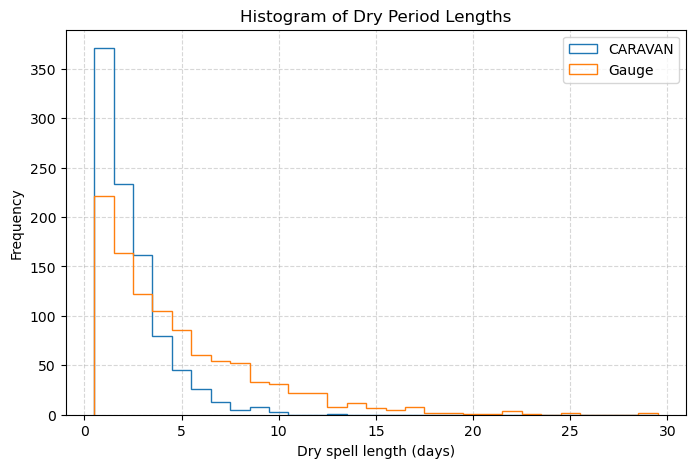

In [18]:
# --- Step 1: Define function to get consecutive zeros ---
def get_consecutive_lengths(bool_array):
    diff = np.diff(bool_array.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1
    if bool_array[0]:
        starts = np.r_[0, starts]
    if bool_array[-1]:
        ends = np.r_[ends, len(bool_array)]
    lengths = ends - starts
    return lengths

# --- Step 2: Convert to boolean arrays for both datasets ---
dry_caravan = (pr_caravan == 0)
dry_gauge   = (pr_gauge   == 0)
# dry_new   = (pr_new   == 0)

# --- Step 3: Get consecutive zero lengths ---
dry_lengths_caravan = get_consecutive_lengths(dry_caravan)
dry_lengths_gauge   = get_consecutive_lengths(dry_gauge)
# dry_lengths_new   = get_consecutive_lengths(dry_new)

# --- Step 4: Plot histograms together ---
plt.figure(figsize=(8,5))

max_len = max(
    dry_lengths_caravan.max(),
    dry_lengths_gauge.max(),
    # dry_lengths_new.max()
)

bins = np.arange(1, max_len + 2) - 0.5

# plt.hist(dry_lengths_caravan, bins=bins, alpha=0.6, label='Caravan', edgecolor='black')
# plt.hist(dry_lengths_gauge, bins=bins, alpha=0.6, label='Gauge', edgecolor='black')
# plt.hist(dry_lengths_new, bins=bins, alpha=0.6, label="MSWEP_V280", edgecolor="black")

plt.hist(dry_lengths_caravan, bins=bins, histtype="step", lw=2, label="CARAVAN")
plt.hist(dry_lengths_gauge,   bins=bins, histtype="step", lw=2, label="Gauge")
# plt.hist(dry_lengths_new,     bins=bins, histtype="step", lw=2, label="MSWEP_V280")

plt.xlabel("Dry spell length (days)")
plt.ylabel("Frequency")
plt.title("Histogram of Dry Period Lengths")
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.show()

## Streamflow with precip histogram

In [19]:
# Replace 'your_file.p' with the path to your .p file
# file_path = 'runs/CAMELS_UY_6_uy_caravan_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_0901_013315/validation/model_epoch030/validation_results.p'
# file_path = 'runs/CAMELS_UY_6_uy_gauge_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_0901_013629/validation/model_epoch030/validation_results.p'
file_path = 'runs/caravan_emoving_10_15_uy_gauges_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_2301_072157/validation/model_epoch030/validation_results.p'


with open(file_path, 'rb') as f:  # 'rb' = read binary
    data = pickle.load(f)

data  # Check what kind of object it is

{'CAMELS_UY_16': {'1D': {'xr': <xarray.Dataset> Size: 58kB
   Dimensions:        (date: 3652, time_step: 1)
   Coordinates:
     * date           (date) datetime64[ns] 29kB 1989-10-01 ... 1999-09-30
     * time_step      (time_step) int64 8B 0
   Data variables:
       QObs_mm_d_obs  (date, time_step) float32 15kB 0.1311 0.1247 ... nan nan
       QObs_mm_d_sim  (date, time_step) float32 15kB -0.004648 0.1031 ... 0.03592,
   'NSE': 0.008371829986572266,
   'KGE': np.float64(0.27093821409050856),
   'Alpha-NSE': 0.684424107083659,
   'Beta-NSE': 0.02811413298440615,
   'Pearson-r': 0.3489052653312683,
   'RMSE': np.float64(2.64984462570445),
   'MSE': 7.021676540374756,
   'Beta-KGE': 1.08954656124115}},
 'CAMELS_UY_3': {'1D': {'xr': <xarray.Dataset> Size: 58kB
   Dimensions:        (date: 3652, time_step: 1)
   Coordinates:
     * date           (date) datetime64[ns] 29kB 1989-10-01 ... 1999-09-30
     * time_step      (time_step) int64 8B 0
   Data variables:
       QObs_mm_d_obs  (dat

In [20]:
# Example: choose one catchment, e.g., CAMELS_UY_10
catchment = 'CAMELS_UY_3'

In [21]:
# Extract the xarray dataset and NSE value
ds = data[catchment]['1D']['xr']
NSE = data[catchment]['1D']['NSE']

In [22]:
# pr_ds = caravan_6_trimmed
uy_gauge = xr.open_dataset(data_uy_gauge / f"{catchment}.nc")

start_date = pd.to_datetime("1989-10-01")
end_date   = pd.to_datetime("2008-09-30")

uy_gauge = uy_gauge.sel(date=slice(start_date, end_date))

pr_ds = uy_gauge
# pr_ds = new_precip_6

pr_ds

<xarray.Dataset> Size: 222kB
Dimensions:      (date: 6940)
Coordinates:
  * date         (date) datetime64[ns] 56kB 1989-10-01 1989-10-02 ... 2008-09-30
Data variables:
    tmin_C       (date) float32 28kB ...
    tmax_C       (date) float32 28kB ...
    srad_W_m2    (date) float32 28kB ...
    prcp_mm_day  (date) float32 28kB ...
    QObs_mm_d    (date) float64 56kB ...
Attributes:
    precip_update:  Gauge data used where available

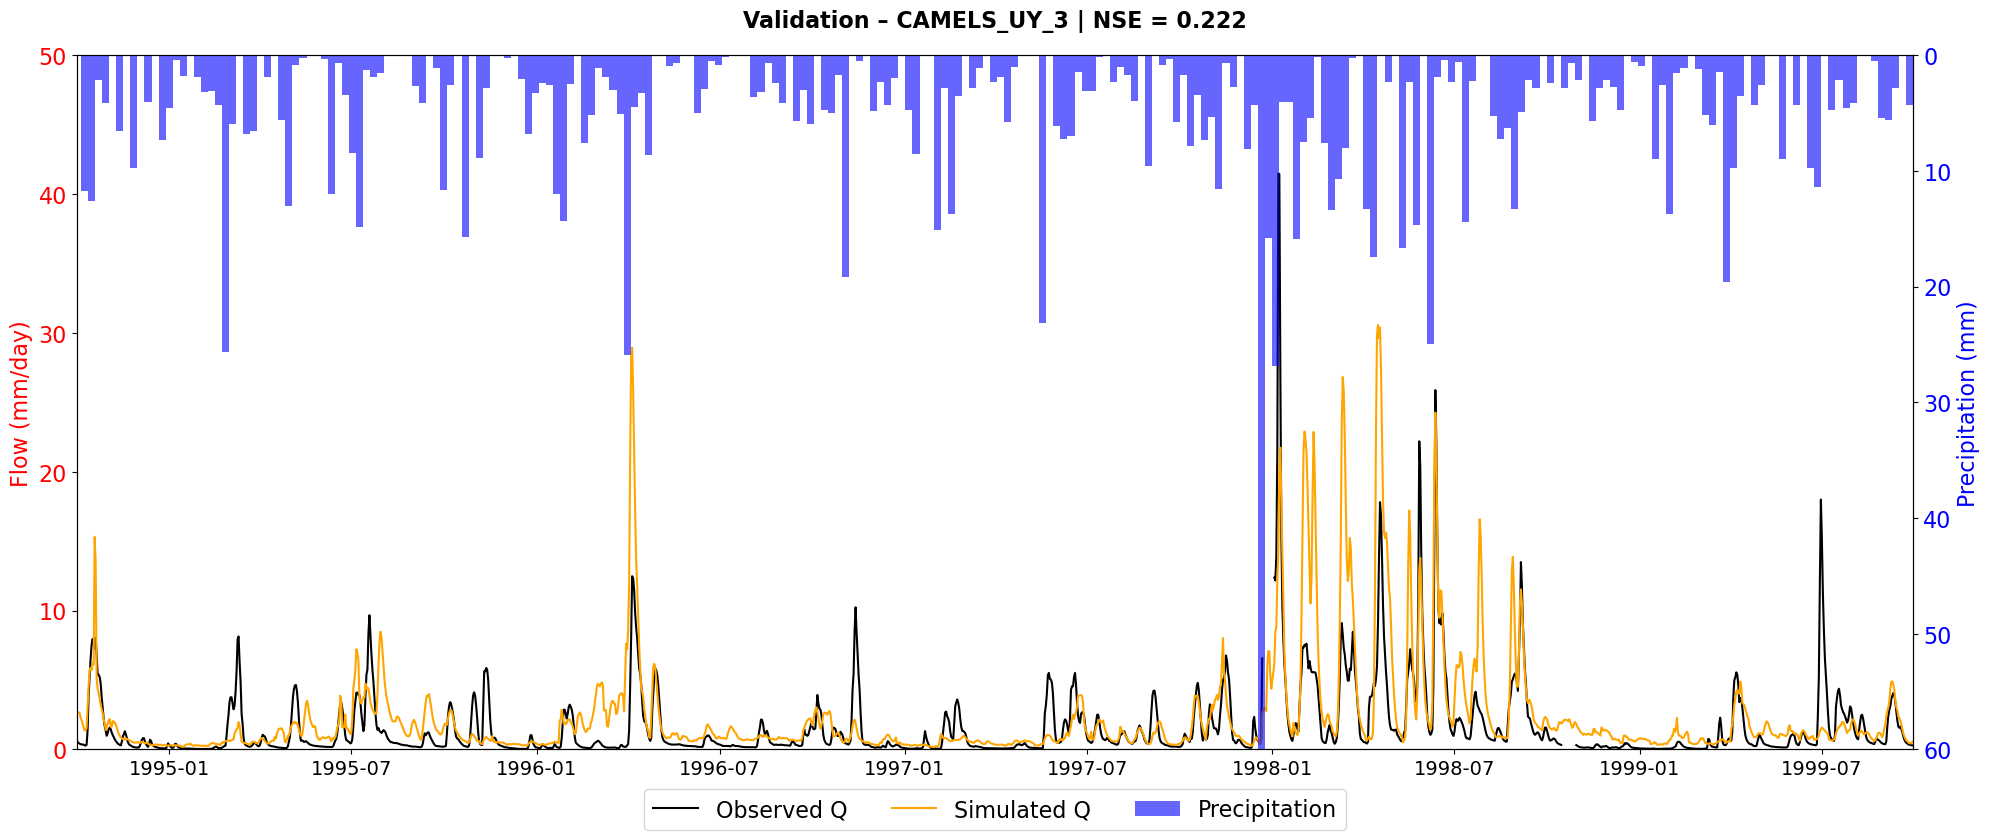

In [23]:
# --------------------------------------------------
# Extract streamflow as pandas
# --------------------------------------------------
time = ds['date'].values
obs = ds['QObs_mm_d_obs'].values.squeeze()
sim = ds['QObs_mm_d_sim'].values.squeeze()

flow_df = pd.DataFrame({
    "obs": obs,
    "sim": sim
}, index=pd.to_datetime(time))

# --------------------------------------------------
# Precipitation: convert to pandas and aggregate
# --------------------------------------------------
precip = pr_ds['prcp_mm_day'].to_pandas()  # pr_ds already aligned to validation period
# precip = pr_ds['total_precipitation_sum'].to_pandas() #caravan
window = "7D"  # e.g., 7-day mean for visualization
precip_agg = precip.resample(window).mean()  # or .sum() if you prefer totals

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, ax_flow = plt.subplots(figsize=(20, 8))

# Streamflow (line)
ax_flow.plot(flow_df.index, flow_df['obs'], color="black", label="Observed Q")
ax_flow.plot(flow_df.index, flow_df['sim'], color="orange", label="Simulated Q")
ax_flow.set_ylabel("Flow (mm/day)",fontsize=16, color="red")
ax_flow.set_ylim(0,50)
ax_flow.tick_params(axis="y", labelcolor="red",labelsize=16)

# Precipitation (bar, aggregated)
ax_precip = ax_flow.twinx()
ax_precip.bar(
    precip_agg.index,
    precip_agg.values,
    width=pd.Timedelta(window).days,
    color="blue",
    alpha=0.6,
    label="Precipitation"
)
ax_precip.set_ylabel("Precipitation (mm)",fontsize=16, color="blue")
ax_precip.invert_yaxis()  # downward bars
ax_precip.tick_params(axis="y", labelcolor="blue",labelsize=16)
ax_precip.set_ylim(60,0)

# Optional: set x-axis limits (e.g., zoom to a period)
# test_start_date= "01/10/1989"
# test_end_date = "30/09/1994"

test_start_date= "01/10/1994"
test_end_date = "30/09/1999"

ax_flow.set_xlim(pd.to_datetime(test_start_date, dayfirst=True), 
                 pd.to_datetime(test_end_date, dayfirst=True))
ax_precip.set_xlim(ax_flow.get_xlim())
ax_flow.tick_params(axis="x", labelsize=14)


# Title
fig.suptitle(f"Validation – {catchment} | NSE = {NSE:.3f}", fontsize=16, fontweight="bold")

# Legend
lines1, labels1 = ax_flow.get_legend_handles_labels()
lines2, labels2 = ax_precip.get_legend_handles_labels()

fig.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.06),
    fontsize=16
)

# start_date = pd.to_datetime("1989-09-01")
# end_date = pd.to_datetime("1999-08-31")
# ax_flow.set_xlim(start_date, end_date)
# ax_precip.set_xlim(start_date, end_date)

plt.tight_layout()
plt.show()
